In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Discrete Spectrum

In [2]:
# import DiscSpec
from discSpec import *

In [3]:
# This runs the code in regular form using inp.dat
par = common.readInput('inp.dat')
_, g, tau, _ = getDiscSpec(par)
plt.clf()

Input parameters look OK ...

(*) Start
(*) Loading Data Files: ... Gst.dat...

(*) Number of optimum nodes = 11

(*) Condition number of matrix equation: 6.216928e+06


		Modes
		-----


i 	    g(i) 	    tau(i)

---------------------------------------

  1 	 5.75863e+05 	 2.49924e-06
  2 	 1.09696e+05 	 2.56665e-05
  3 	 3.70947e+04 	 5.62154e-05
  4 	 5.59274e+04 	 1.06401e-04
  5 	 1.09831e+05 	 2.76655e-04
  6 	 2.40232e+04 	 4.68519e-04
  7 	 2.29766e+04 	 1.25805e-03
  8 	 7.91396e+03 	 9.17452e-03
  9 	 5.21254e+03 	 8.81940e-02
 10 	 5.19627e+03 	 8.84110e-01
 11 	 6.13157e+01 	 1.02414e+01




In [16]:
def guiFurnishGlobals(par):

    # toggle flags to prevent printing    
    par['verbose'] = False
    par['plotting'] = False
    
    # Read experimental data
    w, Gexp = common.GetExpData(par['GexpFile'])

    # Read continuous spectrum
    s, H    = np.loadtxt('output/H.dat', unpack=True)    

    # Read continuous fit
    _, GpC, GppC = np.loadtxt('output/Gfit.dat', unpack=True)
    Gfitc = np.hstack([GpC, GppC])
    
    wt  = GetWeights(H, w, s)
    wt  = wt/np.trapz(wt, np.log(s))
    
    return s, H, w, Gexp, Gfitc, wt

In [17]:
s, H, w, Gexp, Gfitc, wt0 = guiFurnishGlobals(par)

In [25]:
def guiUpdatePlot(BaseDistWt=0.5, condWt=0.5):
    
    wt  = (1. - BaseDistWt) * wt0 + BaseDistWt*np.mean(wt0)*np.ones(len(wt0))

    # calculation
    n     = len(w)

    Nmax  = min(np.floor(3.0 * np.log10(max(w)/min(w))),n/4); # maximum N
    Nmin  = max(np.floor(0.5 * np.log10(max(w)/min(w))),3);   # minimum N

    Nv    = np.arange(Nmin, Nmax + 1).astype(int)
    npts  = len(Nv)
    ev    = np.zeros(npts)
    condN = np.zeros(npts)

    for i in np.arange(npts):
        N      = Nv[i]
        z, hz  = GridDensity(np.log(s),wt,N)     # Select "tau" Points

        # Get g_i
        g, tau, ev[i], condN[i] = MaxwellModes(z, w, Gexp)    

    emin     = min(ev);
    condNmin = min(condN);
    cost     = (1 - par['condWt']) * (ev - emin)**2 + par['condWt']  * (np.log(condN/condNmin))**2
    
    # optimum
    Nopt               = Nv[np.argmin(cost)] 
    z, hz              = GridDensity(np.log(s),wt,Nopt)             # Select "tau" Points
    g, tau, error, cKp = MaxwellModes(z, w, Gexp)   # Get g_i
    
    # plotting
    
    fig, ax = plt.subplots(figsize=(14,4), nrows=1, ncols=3)

    # continuous and discrete spectra
    ax[0].loglog(tau, g,'o-', label='disc')
    ax[0].loglog(s, np.exp(H), label='cont')
    ax[0].set_xlabel(r'$\tau$')
    ax[0].set_ylabel(r'$g$')
    ax[0].legend(loc='lower right')

    # predicted and actual values
    S, W    = np.meshgrid(tau, w)    
    ws      = S*W
    ws2     = ws**2
    K       = np.vstack((ws2/(1+ws2), ws/(1+ws2)))   # 2n * nmodes
    GstM    = np.dot(K, g)
 
    ax[1].loglog(w, Gexp[:n],'g.')
    ax[1].loglog(w, Gexp[n:],'g.')

    ax[1].loglog(w, GstM[:n], 'k-', label='disc')
    ax[1].loglog(w, GstM[n:], 'k-')

    ax[1].loglog(w, GstM[:n], 'k-', label='disc')
    ax[1].loglog(w, GstM[n:], 'k-')

    ax[1].loglog(t,Gfitc[:n], label='cont')

    ax[1].set_xlabel(r'$\omega$')
    ax[1].set_ylabel(r'$G^{*}$$')    
    
    ax[1].legend(loc='lower left')

    ax[2].plot(Nv, ev, label='error')
    ax[2].plot(Nv, condN, label='cond#')
    ax[2].plot(Nv, cost, '--', label='costFn')
    ax[2].set_yscale('log')
    ax[2].set_xlabel('# modes')
    ax[2].scatter(Nopt, np.min(cost))
    ax[2].legend()

    # figure settings
    fig.tight_layout()
    
    plt.show()    

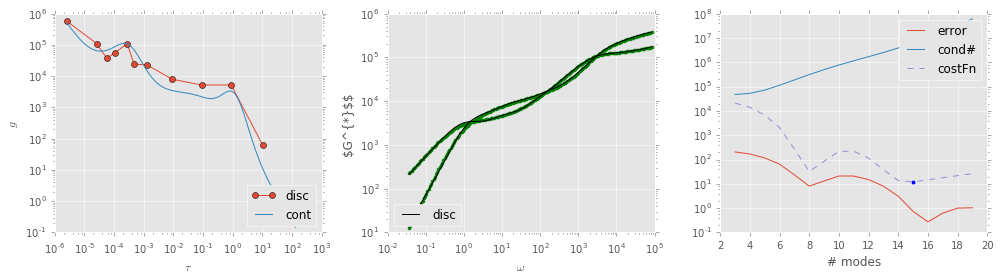

In [26]:
guiUpdatePlot()

In [ ]:
guiUpdatePlot(BaseDistWt=0.5, condWt=0.5)

### Interactivity

In [ ]:
from ipywidgets import interact, fixed
import ipywidgets as widgets

In [ ]:
SBaseDistWt = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05, continuous_update=False)
ScondWt = widgets.FloatSlider(min=0, max=1, value=0.5, step=0.05, continuous_update=False)
interact(guiUpdatePlot, BaseDistWt=SBaseDistWt, condWt=ScondWt)